# Mount Google Drive to access dataset

In [1]:
# Mount Google drive to access dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/42028/ASSESSMENT_1_A/Train_Test_Folder

/content/gdrive/MyDrive/42028/ASSESSMENT_1_A/Train_Test_Folder


# Import required packages

In [3]:
# Import necessary packages
import matplotlib.pyplot as plt
from skimage import feature # This pacakge is used for LBP feature extraction
from sklearn import svm # This pacakge is used for svm classification
from sklearn import metrics
%matplotlib inline
import cv2
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)
# import the packages required 
  
 
from IPython.display import display, HTML, clear_output
## Import the required packages ##
import math, numpy as np
import sklearn.datasets
import os
import h5py
import glob
import keras.utils as image
import tensorflow as tf

%load_ext tensorboard
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)


2.11.0
2.11.0


# Helper function to load dataset

In [4]:
def loadDataset():

  ## Read all the train and test images, flatten them and change them to grayscale for training and testing
  train_path   = "./train"
  test_path    = "./test"
  train_labels = os.listdir(train_path)
  test_labels  = os.listdir(test_path) 

  image_size       = (45, 45)
  num_train_images = 3500
  num_test_images  = 1500

  train_x = np.zeros(((image_size[0]*image_size[1]), num_train_images))
  train_y = np.zeros((1, num_train_images))
  test_x  = np.zeros(((image_size[0]*image_size[1]), num_test_images))
  test_y  = np.zeros((1, num_test_images))

  #----------------
  # TRAIN dataset
  #----------------
  count = 0
  num_label = 0
  for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label
    print(glob.glob(cur_path + "/*.jpg"))
    for image_path in glob.glob(cur_path + "/*.jpg"):
      img = cv2.imread(image_path)
      # Change from color to grayscale
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #print(image_path)
      x   = np.asarray(img)
      x   = x.flatten()
      x   = np.expand_dims(x, axis=0)
      train_x[:,count] = x
      train_y[:,count] = num_label
      count += 1
    num_label += 1

  #--------------
  # TEST dataset
  #--------------
  count = 0 
  num_label = 0 
  for i, label in enumerate(test_labels):
    cur_path = test_path + "/" + label
    for image_path in glob.glob(cur_path + "/*.jpg"):
      img = cv2.imread(image_path)
      # Change from color to grayscale
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      x   = np.asarray(img)
      x   = x.flatten()
      x   = np.expand_dims(x, axis=0)
      test_x[:,count] = x
      test_y[:,count] = num_label
      count += 1
    num_label += 1

  #------------------
  # standardization
  #------------------
  train_x = train_x/255.
  test_x  = test_x/255.


  ## Print the statistics of the data
  print ("train_labels : " + str(train_labels))
  print ("train_x shape: " + str(train_x.shape))
  print ("train_y shape: " + str(train_y.shape))
  print ("test_x shape : " + str(test_x.shape))
  print ("test_y shape : " + str(test_y.shape))

  return train_x, train_y, test_x, test_y

# SVM

In [5]:
# Load the dataset

In [6]:
X_train, y_train, X_test, y_test = loadDataset()

['./train/!/exp22012.jpg', './train/!/exp10309.jpg', './train/!/exp23386.jpg', './train/!/exp21731.jpg', './train/!/!_15475.jpg', './train/!/exp11407.jpg', './train/!/exp28682.jpg', './train/!/exp101071.jpg', './train/!/!_95964.jpg', './train/!/exp16347.jpg', './train/!/exp24677.jpg', './train/!/exp13461.jpg', './train/!/!_25845.jpg', './train/!/exp13456.jpg', './train/!/exp81442.jpg', './train/!/exp100213.jpg', './train/!/exp89445.jpg', './train/!/!_14337.jpg', './train/!/exp17420.jpg', './train/!/exp20594.jpg', './train/!/exp11401.jpg', './train/!/!_12590.jpg', './train/!/!_95970.jpg', './train/!/exp21739.jpg', './train/!/exp9755.jpg', './train/!/exp10843.jpg', './train/!/exp22084.jpg', './train/!/exp26429.jpg', './train/!/exp9967.jpg', './train/!/!_9086.jpg', './train/!/exp9745.jpg', './train/!/exp22342.jpg', './train/!/exp12774.jpg', './train/!/exp84995.jpg', './train/!/!_25553.jpg', './train/!/exp11043.jpg', './train/!/exp12011.jpg', './train/!/exp22623.jpg', './train/!/exp97390.j

In [7]:
# Transpose training and test samples
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [8]:
# Reshape training and test x samples

X_train=X_train.reshape(-1,45,45)
X_test=X_test.reshape(-1,45,45)

# print the size of the result reshaped train and test data splits

print("Train dataset after reshaping:{}".format(np.shape(X_train)))
print("Test dataset after reshaping :{}".format(np.shape(X_test)))

Train dataset after reshaping:(3500, 45, 45)
Test dataset after reshaping :(1500, 45, 45)


In [9]:
# Define the class for LBP
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
 
	def LBPfeatures(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
    # Form the histogram
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
 
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
 
		# return the histogram of Local Binary Patterns
		return hist

In [10]:
# Create an object of LocalBinaryPatterns class and initial the parameters.
desc = LocalBinaryPatterns(24, 8)
data_train = []
labels_train = []

# loop over the training images
for img_index in range(len(X_train)):
	# load the image, convert it to grayscale, and extract LBP features
	image = (X_train[img_index])
	hist = desc.LBPfeatures(image)
 
	# extract the label from the image path, then update the
	# label and data lists
	labels_train.append(y_train[img_index])
	data_train.append(hist)

In [11]:
# Check the shape of the new features created

In [12]:

np.shape(data_train)

(3500, 26)

In [13]:
np.shape(labels_train)

(3500, 1)

In [14]:
# train a SVM clasifier on the training data
# Initialize the SVM model
model = svm.SVC(kernel='rbf',C=100.0, random_state=42) # rbf Kernel
# Start training the SVM classifier 
model.fit(data_train, labels_train)

print(np.shape(data_train))
print(np.shape(labels_train))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(3500, 26)
(3500, 1)


In [15]:
# Check the training accuray
print("Train set Accuracy: {:.2f}".format(model.score(data_train,labels_train)))

# Expected training set Accuracy 0.60

Train set Accuracy: 0.69


In [16]:
predictions=[]
predict_label=[]
# Extract LBP features for each test sample and classify it with the trained SVM classifier
for im_index in range(len(X_test)):
  imag = X_test[im_index]
  # Extract LBP feature
  histo = desc.LBPfeatures(imag)
  # Perform classification
  prediction = model.predict(histo.reshape(1, -1))
  # Store the classfication result
  predictions.append(prediction)
  predict_label.append(y_test[im_index])

In [17]:
# Check accuracy on test dataset
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy on test dataset:",accuracy)

Accuracy on test dataset: 0.6966666666666667


[[109  38   2   0   0   0   1   0   0   0]
 [  1 149   0   0   0   0   0   0   0   0]
 [  5   2 125   2   2   8   0   3   1   2]
 [  0   0   2  95   4   3  16   9   0  21]
 [  0   0   2  32  60   8  13  18   5  12]
 [  0   0   0   7  13 100  19   0   0  11]
 [  0   0   3  11   2  14  89   5  16  10]
 [  0   0   8   7  16   7   3  95  14   0]
 [  0   0   2   3   8   3  12   2  97  23]
 [  0   0   1   2   1  10   5   0   5 126]]


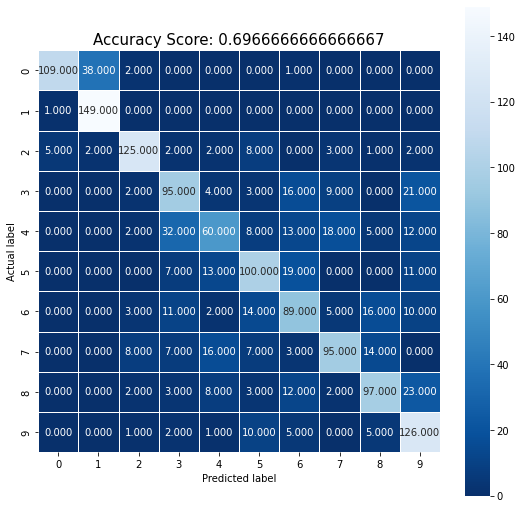

In [18]:
# plot the confusion matrix
cm  = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix using seaborn library
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

# ANN

In [19]:
# Load the dataset
X_train, y_train, X_test, y_test = loadDataset()

['./train/!/exp22012.jpg', './train/!/exp10309.jpg', './train/!/exp23386.jpg', './train/!/exp21731.jpg', './train/!/!_15475.jpg', './train/!/exp11407.jpg', './train/!/exp28682.jpg', './train/!/exp101071.jpg', './train/!/!_95964.jpg', './train/!/exp16347.jpg', './train/!/exp24677.jpg', './train/!/exp13461.jpg', './train/!/!_25845.jpg', './train/!/exp13456.jpg', './train/!/exp81442.jpg', './train/!/exp100213.jpg', './train/!/exp89445.jpg', './train/!/!_14337.jpg', './train/!/exp17420.jpg', './train/!/exp20594.jpg', './train/!/exp11401.jpg', './train/!/!_12590.jpg', './train/!/!_95970.jpg', './train/!/exp21739.jpg', './train/!/exp9755.jpg', './train/!/exp10843.jpg', './train/!/exp22084.jpg', './train/!/exp26429.jpg', './train/!/exp9967.jpg', './train/!/!_9086.jpg', './train/!/exp9745.jpg', './train/!/exp22342.jpg', './train/!/exp12774.jpg', './train/!/exp84995.jpg', './train/!/!_25553.jpg', './train/!/exp11043.jpg', './train/!/exp12011.jpg', './train/!/exp22623.jpg', './train/!/exp97390.j

In [20]:
# Transpose training and test samples
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [21]:
# Reshape training and test x samples

X_train=X_train.reshape(-1,45,45)
X_test=X_test.reshape(-1,45,45)

# print the size of the result reshaped train and test data splits

print("Train dataset after reshaping:{}".format(np.shape(X_train)))
print("Test dataset after reshaping :{}".format(np.shape(X_test)))

Train dataset after reshaping:(3500, 45, 45)
Test dataset after reshaping :(1500, 45, 45)


In [22]:
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
 
	def LBPfeatures(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
    # Form the histogram
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
 
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
 
		# return the histogram of Local Binary Patterns
		return hist

In [23]:
# Create an object of LocalBinaryPatterns class and initial the parameters.
desc = LocalBinaryPatterns(24, 8)
data_train = []
labels_train = []

# loop over the training images
for img_index in range(len(X_train)):
	# load the image, convert it to grayscale, and extract LBP features
	image = (X_train[img_index])
	hist = desc.LBPfeatures(image)
 
	# extract the label from the image path, then update the
	# label and data lists
	labels_train.append(y_train[img_index])
	data_train.append(hist)

In [24]:
labels_test = []
data_test=[]
# Extract LBP features for each test sample and classify it with the trained SVM classifier
for im_index in range(len(X_test)):
  imag = X_test[im_index]
  # Extract LBP feature
  histo = desc.LBPfeatures(imag)
  data_test.append(histo)
  labels_test.append(y_test[im_index])

In [25]:
# Check the shape of the new features created

In [26]:
print(np.shape(data_train))
print(np.shape(labels_train))
print(np.shape(data_test))
print(np.shape(labels_test))

(3500, 26)
(3500, 1)
(1500, 26)
(1500, 1)


In [27]:
# Transform features into numpy arrays to feed them to the model and reshape labels

In [28]:
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
labels_train = labels_train.reshape(-1)
labels_test = labels_test.reshape(-1)
data_train = np.array(data_train)
data_test = np.array(data_test)

In [29]:
# Check the shape of the features created

In [30]:
print(np.shape(data_train))
print(np.shape(labels_train))
print(np.shape(data_test))
print(np.shape(labels_test))

(3500, 26)
(3500,)
(1500, 26)
(1500,)


In [31]:
# Design and train the model
model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
H = model.fit(data_train, labels_train, epochs=10,validation_data=(data_test, labels_test))

Epoch 1/10
110/110 [==============================] - 2s 11ms/step - loss: 2.2333 - accuracy: 0.1823 - val_loss: 2.1460 - val_accuracy: 0.2060
Epoch 2/10
110/110 [==============================] - 1s 11ms/step - loss: 2.0423 - accuracy: 0.2377 - val_loss: 1.9362 - val_accuracy: 0.2387
Epoch 3/10
110/110 [==============================] - 1s 9ms/step - loss: 1.8724 - accuracy: 0.2949 - val_loss: 1.8135 - val_accuracy: 0.2907
Epoch 4/10
110/110 [==============================] - 1s 8ms/step - loss: 1.7818 - accuracy: 0.3063 - val_loss: 1.7403 - val_accuracy: 0.3627
Epoch 5/10
110/110 [==============================] - 1s 5ms/step - loss: 1.7227 - accuracy: 0.3243 - val_loss: 1.6910 - val_accuracy: 0.3947
Epoch 6/10
110/110 [==============================] - 1s 5ms/step - loss: 1.6786 - accuracy: 0.3446 - val_loss: 1.6497 - val_accuracy: 0.4067
Epoch 7/10
110/110 [==============================] - 0s 4ms/step - loss: 1.6421 - accuracy: 0.3771 - val_loss: 1.6194 - val_accuracy: 0.4247
Epoc

Accuracy on test dataset: 0.4340
